In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

from sklearn.metrics import f1_score, accuracy_score,make_scorer
from sklearn.metrics import classification_report, confusion_matrix
import pickle

## Data loading and cleaning

In [2]:
data_hit = pd.read_csv('./Top_200.csv')
data_hit = data_hit.dropna()

def get_id(url):
    return url.split('/')[-1]

# Convert link to ID
data_hit["ID"] = data_hit["Link"].apply(get_id)

# Remove duplicate
data_hit = data_hit.drop_duplicates(subset=['ID'])
data_hit.head()

,Rank,Track,Artist,Streams,Link,Week,Album_Name,Duration_MS,Explicit,Track_Number_on_Album,...,Key,Mode,Instrumentalness,Liveness,Loudness,Speechiness,Valence,Tempo,Time Signature,Popularity
0,1,Starboy,The Weeknd,25734078,https://open.spotify.com/track/5aAx2yezTd8zXrk...,1/6/2017,Starboy,230453,True,1,...,7,1,0.000003,0.134,-7.028,0.2820,0.5350,186.054,4,1
1,2,Closer,The Chainsmokers,23519705,https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,1/6/2017,Closer,244960,False,1,...,8,1,0.000000,0.111,-5.599,0.0338,0.6610,95.010,4,86
2,3,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,21216399,https://open.spotify.com/track/5knuzwU65gJK7IF...,1/6/2017,Rockabye (feat. Sean Paul & Anne-Marie),251088,False,1,...,9,0,0.000000,0.180,-4.068,0.0523,0.7420,101.965,4,78
3,4,Let Me Love You,DJ Snake,19852704,https://open.spotify.com/track/4pdPtRcBmOSQDlJ...,1/6/2017,Encore,205946,False,13,...,8,1,0.000010,0.122,-5.309,0.0576,0.1420,199.864,4,0
4,5,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,18316326,https://open.spotify.com/track/3NdDpSvN911VPGi...,1/6/2017,I Don’t Wanna Live Forever (Fifty Shades Darker),245200,False,1,...,0,1,0.000013,0.325,-8.374,0.0585,0.0862,117.973,4,1


In [3]:
data_n_hit = pd.read_csv('./Random_song.csv')
data_n_hit = data_n_hit.drop_duplicates(subset=['ID'])
data_n_hit = data_n_hit.dropna()
data_n_hit.head()

,ID,Artist,Track,Popularity,Acousticness,Danceablility,Energy,Key,Mode,Instrumentalness,Liveness,Loudness,Speechiness,Valence,Tempo,Time Signature
0,2b8fOow8UzyDFAE27YhOZM,Maroon 5,Memories,99,0.8370,0.764,0.320,11,1,0.00000,0.0822,-7.209,0.0546,0.575,91.019,4
1,6WrI0LAC5M1Rw2MnX2ZvEg,Dua Lipa,Don't Start Now,95,0.0125,0.794,0.793,11,0,0.00000,0.0952,-4.521,0.0842,0.677,123.941,4
2,3ZCTVFBt2Brf31RLEnCkWJ,Billie Eilish,everything i wanted,94,0.9020,0.704,0.225,6,0,0.65700,0.1060,-14.454,0.0994,0.243,120.006,4
3,696DnlkuDOXcMAnKlTgXXK,Arizona Zervas,ROXANNE,88,0.0522,0.621,0.601,6,0,0.00000,0.4600,-5.616,0.1480,0.457,116.735,5
4,4VginDwYTP2eaHJzO0QMjG,Post Malone,Circles,68,0.2330,0.704,0.758,0,1,0.00144,0.0924,-3.537,0.0402,0.534,120.003,4


In [4]:
# Divide the dataset into 4 sub-dataset and label each subset 
ranking = data_hit[data_hit['Rank'] <=20]
ranking.loc[(ranking['Rank'] <= 5), 'Label'] = 1
ranking.loc[(ranking['Rank'] > 5) & (ranking['Rank'] <= 10) , 'Label'] = 2
ranking.loc[(ranking['Rank'] > 10) & (ranking['Rank'] <= 15) , 'Label'] = 3
ranking.loc[(ranking['Rank'] > 15) & (ranking['Rank'] <= 20) , 'Label'] = 4
ranking

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Rank,Track,Artist,Streams,Link,Week,Album_Name,Duration_MS,Explicit,Track_Number_on_Album,...,Mode,Instrumentalness,Liveness,Loudness,Speechiness,Valence,Tempo,Time Signature,Popularity,Label
0,1,Starboy,The Weeknd,25734078,https://open.spotify.com/track/5aAx2yezTd8zXrk...,1/6/2017,Starboy,230453,True,1,...,1,0.000003,0.1340,-7.028,0.2820,0.5350,186.054,4,1,1.0
1,2,Closer,The Chainsmokers,23519705,https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,1/6/2017,Closer,244960,False,1,...,1,0.000000,0.1110,-5.599,0.0338,0.6610,95.010,4,86,1.0
2,3,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,21216399,https://open.spotify.com/track/5knuzwU65gJK7IF...,1/6/2017,Rockabye (feat. Sean Paul & Anne-Marie),251088,False,1,...,0,0.000000,0.1800,-4.068,0.0523,0.7420,101.965,4,78,1.0
3,4,Let Me Love You,DJ Snake,19852704,https://open.spotify.com/track/4pdPtRcBmOSQDlJ...,1/6/2017,Encore,205946,False,13,...,1,0.000010,0.1220,-5.309,0.0576,0.1420,199.864,4,0,1.0
4,5,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,18316326,https://open.spotify.com/track/3NdDpSvN911VPGi...,1/6/2017,I Don’t Wanna Live Forever (Fifty Shades Darker),245200,False,1,...,1,0.000013,0.3250,-8.374,0.0585,0.0862,117.973,4,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43817,18,Calling My Phone,Lil Tjay,16168733,https://open.spotify.com/track/3J8EOeKLTLXORtW...,4/9/2021,Destined 2 Win,205458,True,3,...,0,0.000001,0.1350,-7.636,0.0539,0.2020,104.949,4,85,4.0
44000,1,MONTERO (Call Me By Your Name),Lil Nas X,55582612,https://open.spotify.com/track/67BtfxlNbhBmCDR...,4/16/2021,MONTERO (Call Me By Your Name),137875,True,1,...,0,0.000000,0.3840,-6.682,0.1520,0.7580,178.818,4,87,1.0
44002,3,RAPSTAR,Polo G,32132548,https://open.spotify.com/track/43PGPuHIlVOc04j...,4/16/2021,RAPSTAR,165925,True,1,...,1,0.000000,0.1290,-6.862,0.2420,0.4370,81.039,4,84,1.0
44005,6,Kiss Me More (feat. SZA),Doja Cat,24193588,https://open.spotify.com/track/748mdHapucXQri7...,4/16/2021,Kiss Me More (feat. SZA),208866,True,1,...,1,0.000158,0.1230,-3.541,0.0286,0.7420,110.968,4,91,2.0


In [5]:
# Get feature
features = ['ID','Track', 'Acousticness', 'Danceablility','Energy','Key','Mode','Instrumentalness',
            'Liveness','Loudness','Speechiness','Valence','Tempo', 'Popularity','Label']
select_hit = ranking[features]

In [6]:
# Get 550 random songs
data_n_hit['Label'] = 0
select_n_hit = data_n_hit[850:1000][features]

In [7]:
data = pd.concat([select_hit,select_n_hit])
#select_df.groupby('Label').count()
label_ = data.groupby('Label').size()
print("Number of songs in top 5: ", label_[1])
print("Number of songs in top 5-10: ", label_[2])
print("Number of songs in top 10-15: ", label_[3])
print("Number of songs in top 15-20: ", label_[4])
print("Number of random songs: ", label_[0])

Number of songs in top 5:  154
Number of songs in top 5-10:  101
Number of songs in top 10-15:  106
Number of songs in top 15-20:  111
Number of random songs:  150


In [8]:
data = data.drop_duplicates(subset=['ID'])
label_ = data.groupby('Label').size()
print("Number of songs in top 5: ", label_[1])
print("Number of songs in top 5-10: ", label_[2])
print("Number of songs in top 10-15: ", label_[3])
print("Number of songs in top 15-20: ", label_[4])
print("Number of random songs: ", label_[0])

# Get label
y = np.array(data['Label'])
data.head()

Number of songs in top 5:  154
Number of songs in top 5-10:  101
Number of songs in top 10-15:  106
Number of songs in top 15-20:  111
Number of random songs:  147


,ID,Track,Acousticness,Danceablility,Energy,Key,Mode,Instrumentalness,Liveness,Loudness,Speechiness,Valence,Tempo,Popularity,Label
0,5aAx2yezTd8zXrkmtKl66Z,Starboy,0.1650,0.681,0.594,7,1,0.000003,0.134,-7.028,0.2820,0.5350,186.054,1,1.0
1,7BKLCZ1jbUBVqRi2FVlTVw,Closer,0.4140,0.748,0.524,8,1,0.000000,0.111,-5.599,0.0338,0.6610,95.010,86,1.0
2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),0.4060,0.720,0.763,9,0,0.000000,0.180,-4.068,0.0523,0.7420,101.965,78,1.0
3,4pdPtRcBmOSQDlJ3Fk945m,Let Me Love You,0.0784,0.476,0.718,8,1,0.000010,0.122,-5.309,0.0576,0.1420,199.864,0,1.0
4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,0.0631,0.735,0.451,0,1,0.000013,0.325,-8.374,0.0585,0.0862,117.973,1,1.0


([<matplotlib.patches.Wedge at 0x160a88d8b80>,
 [Text(0.8078021292979108, 0.7466295734176095, 'N_HIT'),
  Text(-0.7110973187709768, 0.8392500242697215, 'TOP_5'),
  Text(-1.0015417740969972, -0.45487808777587846, 'TOP_10'),
  Text(-0.10313003191154521, -1.0951548733023673, 'TOP_15'),
  Text(0.930015006845669, -0.5874283675835298, 'TOP_20')],
 [Text(0.44061934325340585, 0.4072524945914233, '23.75'),
  Text(-0.3878712647841691, 0.4577727405107571, '24.88'),
  Text(-0.5462955131438165, -0.24811532060502456, '16.32'),
  Text(-0.056252744679024656, -0.597357203619473, '17.12'),
  Text(0.5072809128249103, -0.32041547322737984, '17.93')])

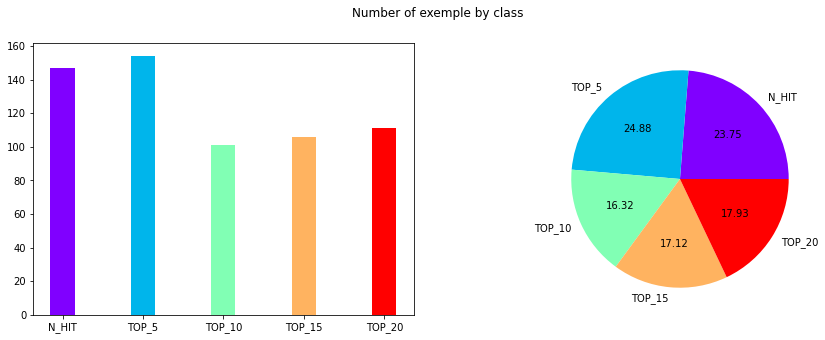

In [9]:
# Visualize the subset
count_label = {"N_HIT":label_[0],"TOP_5":label_[1], "TOP_10":label_[2], "TOP_15":label_[3], "TOP_20":label_[4]}
colors = cm.rainbow(np.linspace(0, 1, len(count_label)))

plt.figure(1,figsize=(15,5))
plt.suptitle("Number of exemple by class")
plt.subplot(1,2,1)
plt.bar(count_label.keys(), count_label.values(),width=0.3,color=colors)
plt.subplot(1,2,2)
plt.pie(count_label.values(), labels = count_label.keys(), autopct = '%0.2f',colors=colors)

In [10]:
#preprocess data
cat_ft  = ['Key', 'Mode']
num_ft = ['Acousticness', 'Danceablility','Energy','Instrumentalness',
            'Liveness','Loudness','Speechiness','Valence','Tempo', 'Popularity']
# ordinal encoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
            ('num', numeric_transformer, num_ft),
            ('cat', categorical_transformer, cat_ft)])
X = data[num_ft + cat_ft]
y = data['Label']

### PCA

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Learning Base Dimension:  (619, 12)


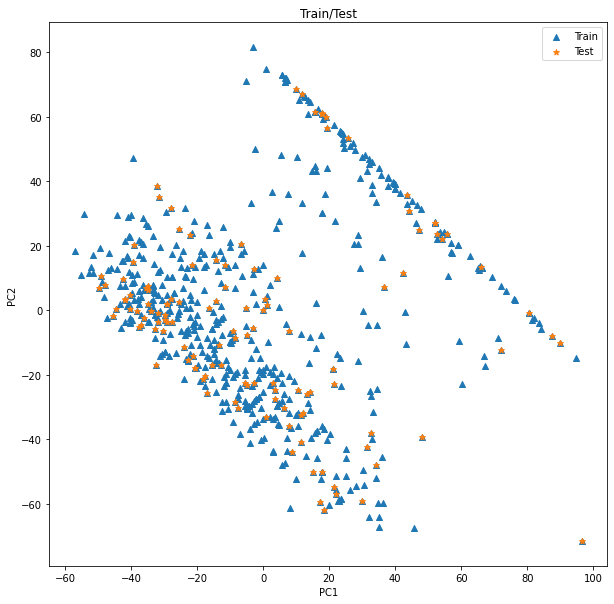

In [12]:
n_components = 2 
print('Learning Base Dimension: ',X.shape)
# using sklearn    
pca = PCA(n_components)
pca_train = pca.fit_transform(X)
pca_test = pca.transform(X_test)

n_components = pca.n_components_
plt.figure(1,figsize=(10,10))
plt.scatter(pca_train[:, 0], pca_train[:, 1],marker='^', label = "Train")
plt.scatter(pca_test[:, 0], pca_test[:, 1],marker='*',label = "Test")
plt.legend()
plt.title("Train/Test")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()

### Model fitting and prediction

In [17]:
def MLpipe_KFold_acc(ML_algo, param_grid):
    
    
    #applies KFold with 4 folds to other
    kf = KFold(n_splits=4,shuffle=True,random_state=42)
    
        
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('scaler', StandardScaler()),
                                     ('classifier', ML_algo)])
    # use GridSearchCV
    # GridSearchCV loops through all parameter combinations and collects the results
    #use acc as score
    grid = GridSearchCV(model_pipeline, param_grid=param_grid,scoring = make_scorer(accuracy_score, greater_is_better=True),
                            cv=kf, return_train_score = True, n_jobs=-1, verbose=False)

    # this line actually fits the model on other
    grid.fit(X_test, y_test)
        
    #best_param = grid.best_params_
    y_predict = grid.predict(X_test)
        
    acc_test= accuracy_score(y_test,  y_predict)
    acc_train = accuracy_score(y_train,  grid.predict(X_train))
    best_models = grid.best_estimator_
        
    return best_models, acc_test, acc_train

In [18]:
param_grid_LR = {'classifier__C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
              'classifier__max_iter': [100000]}

LR_models, LR_acc_test, LR_acc_train, = MLpipe_KFold_acc(LogisticRegression(penalty='l1', solver='saga'),param_grid_LR)
print("Accuracy on test set : ",LR_acc_test)
print("Accuracy on train set : ",LR_acc_train)


Accuracy on test set :  0.25806451612903225
Accuracy on train set :  0.23232323232323232


In [20]:

param_grid_SVC = {'classifier__C': [0.001,0.1, 1, 10, 100, 1000, 2000],  
              'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'classifier__kernel': ['rbf']}  

SVC_models, SVC_acc_test, SVC_acc_train= MLpipe_KFold_acc(SVC(),param_grid_SVC)
print("Accuracy on test set : ",SVC_acc_test)
print("Accuracy on train set : ",SVC_acc_train)

Accuracy on test set :  0.5645161290322581
Accuracy on train set :  0.22424242424242424


In [21]:
# Decision Tree
param_grid_RF = {'classifier__criterion': ['entropy', 'gini'],
    'classifier__n_estimators': [450, 500, 550],
              'classifier__max_depth': [4,5,6,7,8,9,10],
              'classifier__max_features': ['auto', 'log2'],   
            }

RF_models, RF_acc_test, RF_acc_train  = MLpipe_KFold_acc(RandomForestClassifier(),param_grid_RF)
print("Accuracy on test set : ",RF_acc_test)
print("Accuracy on train set : ",RF_acc_train)


Accuracy on test set :  1.0
Accuracy on train set :  0.30303030303030304


In [24]:
# Naive Bayes classifier
param_grid_XGB = {'classifier__max_depth': [ 3, 5, 10, 30],
                  'classifier__eval_metric':['mlogloss']}
XGB_models, XGB_acc_test, XGB_acc_train= MLpipe_KFold_acc(XGBClassifier(use_label_encoder=False),param_grid_XGB)
print("Accuracy on test set : ",XGB_acc_test)
print("Accuracy on train set : ",XGB_acc_train)

Accuracy on test set :  1.0
Accuracy on train set :  0.301010101010101


In [23]:
# KNN classifier
param_grid_KNN ={'classifier__n_neighbors': [1, 5, 10, 30, 100], 
                  'classifier__weights': ['uniform', 'distance']}
KNN_models, KNN_acc_test, KNN_acc_train  = MLpipe_KFold_acc(KNeighborsClassifier(),param_grid_KNN)
print("Accuracy on test set : ",KNN_acc_test)
print("Accuracy on train set : ",KNN_acc_train)

Accuracy on test set :  0.28225806451612906
Accuracy on train set :  0.25656565656565655


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.16935484 0.16935484 0.16129032 0.16129032 0.18548387 0.16129032
 0.24193548 0.22580645        nan        nan]
  warnings.warn(
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [1.         1.         0.46505376 1.         0.38172043 1.
 0.30376344 1.                nan        nan]
  warnings.warn(
